```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is used to create figures that illustrates how the 
IEWPF algorithm acts on a particle

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# IEWPF DA loop figures

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw

import pycuda.driver as cuda

import os
import sys
import datetime
from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':16})
rc('text', usetex=True)
rc('xtick', labelsize=14)     
rc('ytick', labelsize=14)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic, config

from SWESimulators import BathymetryAndICs as BC
from SWESimulators import OceanStateNoise
from SWESimulators import OceanNoiseEnsemble
from SWESimulators import BaseOceanStateEnsemble
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import IEWPFOcean
from SWESimulators import EnsemblePlot

#np.random.seed(8) # 8 was fine, but velocities the wrong way...
#np.random.seed(11) # 11 was fine also, but innovation straight north...
np.random.seed(5) # 11 was fine also, but innovation straight north...

In [2]:
%cuda_context_handler gpu_ctx


In [3]:
#Create output directory for images
imgdir='iewpf_loop_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
imgdir = imgdir + "/"
print("Saving figures to " + imgdir)

Saving figures to iewpf_loop_2019_08_13-18_42_33/


# Testing two-stage IEWPF

Here, we make a test of the entire two-stage IEWPF algorithm applied to a suitable test case.

In [11]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 120, "ny": 120,
    #"nx": 15, "ny": 15,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    #"small_scale_perturbation_interpolation_factor": 1,
    "small_scale_perturbation_interpolation_factor": 5,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals(): 
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)

sim = CDKLM16.CDKLM16(**sim_args)

# Initial perturbation
rand_nx, rand_ny = sim.small_scale_model_error.rand_nx, sim.small_scale_model_error.rand_ny
init_rand = np.random.normal(size=(rand_ny, rand_nx))
sim.small_scale_model_error.random_numbers.upload(sim.gpu_stream, init_rand)
sim.small_scale_model_error.perturbSim(sim, q0_scale=100, update_random_field=False)
    
eta_init, hu_init, hv_init = sim.download(True)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 5,
    "num_drifters": 3,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.015**2 #0.02**2
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)

print ("Ready!")


q0:  0.00028492201548162456
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (120, 120)
max_dt:  0.09209086745977402
Ready!


In [12]:
for particle in ensemble.particles:
    perturbation = np.random.normal(size=(rand_ny, rand_nx))
    particle.small_scale_model_error.random_numbers.upload(particle.gpu_stream, perturbation)
    particle.small_scale_model_error.perturbSim(particle, q0_scale=30, update_random_field=False)
    
ensemble.step(ensemble.dt)

0.05000000074505806

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


hei


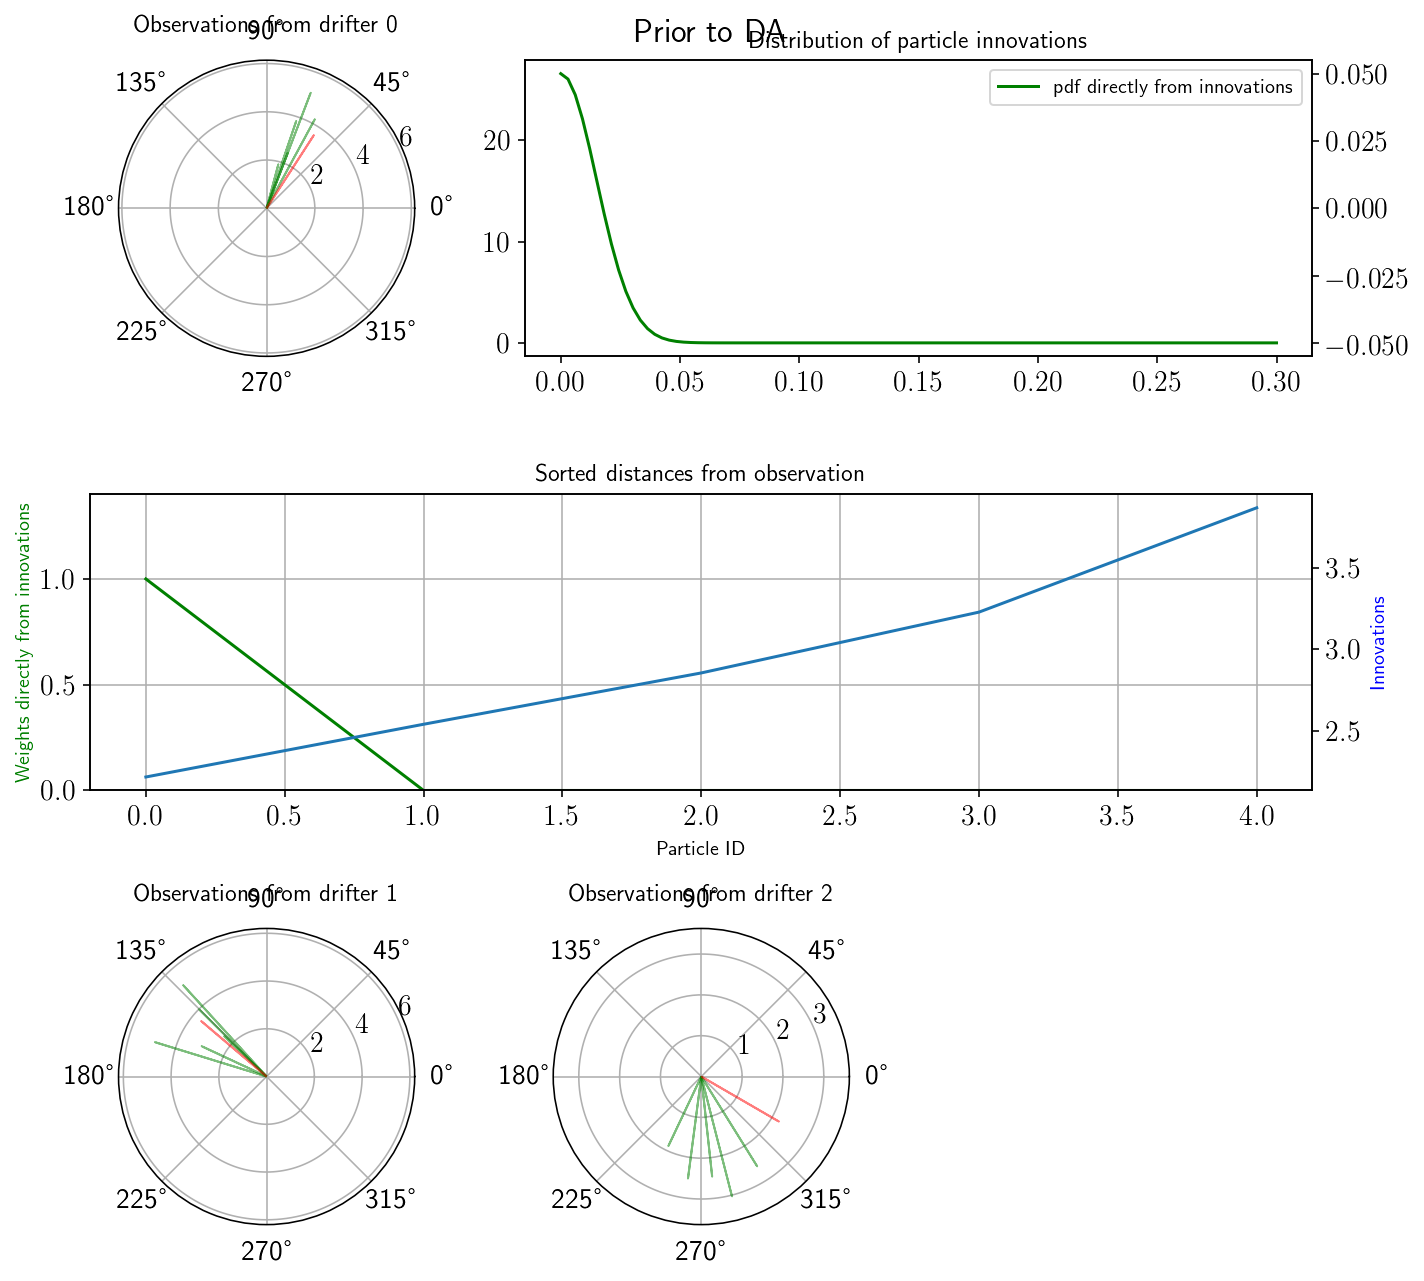

In [13]:
EnsemblePlot.plotVelocityInfo(ensemble, "Prior to DA")
print("hei")

In [14]:
print(ensemble.getInnovations())

[[[ 0.71710645 -0.59962247]
  [ 0.75099883 -1.49782418]
  [ 1.63994536  1.33736658]]

 [[ 0.11086929 -1.78585648]
  [ 0.09308596 -0.49476501]
  [ 0.54131465  1.08619739]]

 [[ 1.45898339  1.20097854]
  [ 1.92817085  0.88417268]
  [ 2.22580279  1.38769689]]

 [[-0.04969641 -0.67159472]
  [-0.96942952  0.64368641]
  [ 1.15822088  1.82073504]]

 [[ 1.06093803  0.70533011]
  [-0.02730276  1.05603747]
  [ 2.70992572  0.58339593]]]


In [15]:
ideal_particle=0

In [16]:
#EnsemblePlot.plotEnsemble(ensemble)

In [35]:
eta_cmap = 'BrBG'
huv_cmap = 'RdBu'

def showMatrices3(eta, hu, hv, title, drifterPositions=None, ensemble=None,
                  title_eta=None, title_hu=None, title_hv=None):
    num_cols = 3
    min_velocity = min(np.min(hu), np.min(hv))
    max_velocity = max(np.max(hu), np.max(hv))
    
    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot(1,num_cols,1)
    plt.imshow(eta, origin="lower", interpolation="None", cmap=eta_cmap)
    if drifterPositions is not None:
        _markDriftersInImshow(ax, drifterPositions, ensemble)
    
    ax = plt.subplot(1,num_cols,2)
    plt.imshow(hu, origin="lower", interpolation="None", 
               vmin=min_velocity, vmax=max_velocity, cmap=huv_cmap)
    if drifterPositions is not None:
        _markDriftersInImshow(ax, drifterPositions, ensemble)

    ax = plt.subplot(1, num_cols, 3)
    plt.imshow(hv, origin="lower", interpolation="None", 
           vmin=min_velocity, vmax=max_velocity, cmap=huv_cmap)
    if drifterPositions is not None:
        _markDriftersInImshow(ax, drifterPositions, ensemble)


def imshow(data, interpolation="None", title=None, figsize=(4,4), interior=False):
    #fig = plt.figure(figsize=figsize)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    
    if interior:
        im = ax.imshow(data[2:-2,2:-2], interpolation=interpolation, origin='lower', cmap=eta_cmap)
    else:
        im = ax.imshow(data, interpolation=interpolation, origin='lower', cmap=eta_cmap)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.colorbar()
    #if title is not None:
    #    plt.title(title, fontsize=15)
    #ny, nx = data.shape
    #axis_label_text = r'$\Omega^R$'
    #if ny == ensemble.ny:
    #    axis_label_text = r'$\Omega^M$'
    #axis_label = plt.text(-nx/6, -ny/6, axis_label_text, fontsize=15)

        
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(13,4), interior=False, infotext=None,
            title_eta=None, title_hu=None, title_hv=None):

    ny, nx = eta.shape
    axis_label_text = r'$\Omega^R$'
    if ny == ensemble.ny:
        axis_label_text = r'$\Omega^M$'
    
    fig = None
    axs = None
    if infotext is None:
        fig, axs = plt.subplots(1,3, figsize=figsize)
    else:
        fig, axs = plt.subplots(1,4, figsize=(figsize[0]*1.33, figsize[1]))
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    if title_eta is not None:
        axs[0].set_title(title_eta, fontsize=20)
    #plt.colorbar(eta_im, ax=axs[0])
    #axis_label = axs[0].text(-nx/6, -ny/6, axis_label_text, fontsize=15)
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    if title_hu is not None:
        axs[1].set_title(title_hu, fontsize=20)
    #plt.colorbar(hu_im, ax=axs[1])
    #axis_label = axs[1].text(-nx/6, -ny/6, axis_label_text, fontsize=15)
    
    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    if title_hv is not None:
        axs[2].set_title(title_hv, fontsize=20)
    #plt.colorbar(hv_im, ax=axs[2])
    #axis_label = axs[2].text(-nx/6, -ny/6, axis_label_text, fontsize=15)

    if infotext is not None:
        axs[3].text(0.5, 0.5, infotext, ha='center')

    plt.subplots_adjust(top=0.88)                        
    if title is not None:
        if infotext is None:
            plt.suptitle(title,  y=1.00, fontsize=20)
        else: 
            plt.suptitle(title, x=3.0/8.0,  y=1.00, fontsize=16)
    
    for ax in axs:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    return fig
        
def createInnovationPlot(ensemble, particle_id, S, 
                         all_innovation_pre=None, all_particle_velocity_pre=None, 
                         use_labels=True):
    
   
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    ax.imshow(np.zeros((ensemble.ny, ensemble.nx))*np.nan, origin="lower")

    #print("S: ", S)
    #print("S*d: ", np.dot(S, innovation))#S*ensemble.getInnovations()[particle_id,:,:].transpose)

    innovation_pre = None
    particle_velocity_pre = None
   
    for drifter in range(ensemble.getNumDrifters()):
        drifter_position = ensemble.observeTrueDrifters()[drifter,:]
        true_velocity = ensemble.observeTrueState()[drifter, 2:]
        all_particle_velocities = ensemble.observeParticles()
        particle_velocity = ensemble.observeParticles()[particle_id,drifter,:]
        innovation = ensemble.getInnovations()[particle_id,drifter,:]
        
        if all_innovation_pre is not None:
            innovation_pre = all_innovation_pre[particle_id, drifter,:]
        if all_particle_velocity_pre is not None:
            particle_velocity_pre = all_particle_velocity_pre[particle_id, drifter, :]

        print("drifter_position", drifter_position)
        print("true_velocity", true_velocity)
        #print("all_particle_velocities", all_particle_velocities)    
        print("particle_velocity", particle_velocity)
        print("innovation: ", innovation)
        
        cell_id_x = int(np.floor(drifter_position[0]/ensemble.dx))
        cell_id_y = int(np.floor(drifter_position[1]/ensemble.dy))
        print("cell_id: ", (cell_id_x, cell_id_y))
    

        circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 2, fill=False)
        ax.add_patch(circ)

        # Add observed particle and truth
        arrow_scale = 4

        if particle_velocity_pre is None:
            particle_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                     particle_velocity[0]*arrow_scale, 
                                                     particle_velocity[1]*arrow_scale, \
                                                     color='xkcd:electric pink', width=0.7)
        else:
            particle_arrow_pre = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                     particle_velocity_pre[0]*arrow_scale, 
                                                     particle_velocity_pre[1]*arrow_scale, \
                                                     color='xkcd:electric pink', width=0.7, alpha=0.2)
            particle_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                     particle_velocity[0]*arrow_scale, 
                                                     particle_velocity[1]*arrow_scale, \
                                                     color='xkcd:electric pink', width=0.7)

        ax.add_patch(particle_arrow)

        truth_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                              true_velocity[0]*arrow_scale, 
                                              true_velocity[1]*arrow_scale, \
                                              color='xkcd:azure', width=0.7)
        ax.add_patch(truth_arrow)

        if innovation_pre is None:
            innovation_arrow = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                       cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                       innovation[0]*arrow_scale, 
                                                       innovation[1]*arrow_scale, 
                                                       linestyle=':',
                                                       color='xkcd:dark slate blue', width=0.7)
        else:
            innovation_arrow_pre = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                       cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                       innovation_pre[0]*arrow_scale, 
                                                       innovation_pre[1]*arrow_scale, 
                                                       linestyle=':', alpha=0.2,
                                                       color='xkcd:dark slate blue', width=0.7)

            innovation_arrow = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                       cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                       innovation[0]*arrow_scale, 
                                                       innovation[1]*arrow_scale, 
                                                       linestyle=':',
                                                       color='xkcd:dark slate blue', width=0.7)


        ax.add_patch(innovation_arrow)
        
        if drifter == 1 and use_labels:
            text_observation = plt.text(cell_id_x+true_velocity[0]*arrow_scale-14, 
                                        cell_id_y+true_velocity[1]*arrow_scale-10, 
                                        r'$y^n$', fontsize=21)
        
        
            if particle_velocity_pre is None:
                text_particle = plt.text(cell_id_x+particle_velocity[0]*arrow_scale+4, 
                                         cell_id_y+particle_velocity[1]*arrow_scale+0, 
                                         r'$H(\psi^n)$', fontsize=21)
            else:
                text_particle = plt.text(cell_id_x+particle_velocity_pre[0]*arrow_scale+8, 
                                         cell_id_y+particle_velocity_pre[1]*arrow_scale-8, 
                                         r'$H(\psi^n)$', fontsize=15, alpha=0.4)
                text_particle = plt.text(cell_id_x+particle_velocity[0]*arrow_scale+3, 
                                         cell_id_y+particle_velocity[1]*arrow_scale+3, 
                                         r'$H(\psi^{n,a})$', fontsize=15)

            if innovation_pre is None:
                text_innovation = plt.text(cell_id_x+innovation[0]*arrow_scale-55, 
                                           cell_id_y+innovation[1]*arrow_scale-18, 
                                           r'$d^n = y^n - H(\psi^n)$', fontsize=21)
            else:
                text_innovation = plt.text(cell_id_x+innovation_pre[0]*arrow_scale-51, 
                                           cell_id_y+innovation_pre[1]*arrow_scale-5, 
                                           r'$d^n = y^n - H(\psi^n)$', fontsize=15, alpha=0.4)
                text_innovation = plt.text(cell_id_x+innovation[0]*arrow_scale-25, 
                                           cell_id_y+innovation[1]*arrow_scale-12, 
                                           r'$d^n = y^n - H(\psi^{n,a})$', fontsize=15)


        #ax.annotate('', xy=(1.2, 0.3), xycoords='axes fraction', xytext=(1.1, 0.4), 
        #        arrowprops=dict(arrowstyle="->", color='green'))
        #fig.canvas.draw()

    #axis_label = plt.text(-ensemble.nx/7, -ensemble.ny/7, r'$\Omega^M$', fontsize=15)

    #plt.title('Observation, particle state and innovation', fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    return ax
            


In [18]:
ensemble.getNumDrifters()

3

## Start IEWPF algorithm

In [19]:
# Observe states and create arrays
observed_drifter_positions = ensemble.observeTrueDrifters()
innovations = ensemble.getInnovations()

# Needed for making the final vector plot
all_particle_velocities_pre = ensemble.observeParticles()
innovation_pre = ensemble.getInnovations()
w_rest = -np.log(1.0/ensemble.getNumParticles())*np.ones(ensemble.getNumParticles())


phi_array     = np.zeros(ensemble.getNumParticles())
nu_norm_array = np.zeros(ensemble.getNumParticles())
gamma_array   = np.zeros(ensemble.getNumParticles())


drifter_position [120.009796 120.01515 ]
true_velocity [1.94996381 3.01669121]
particle_velocity [1.22305524 3.60114932]
innovation:  [ 0.71710645 -0.59962247]
cell_id:  (30, 30)
drifter_position [359.98657 120.00803]
true_velocity [-2.72713113  2.31245995]
particle_velocity [-3.48499703  3.81610703]
innovation:  [ 0.75099883 -1.49782418]
cell_id:  (89, 30)
drifter_position [120.013336 359.9917  ]
true_velocity [ 1.88973868 -1.09623325]
particle_velocity [ 0.26543772 -2.44267511]
innovation:  [1.63994536 1.33736658]
cell_id:  (30, 89)


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/ma/core.py:713:

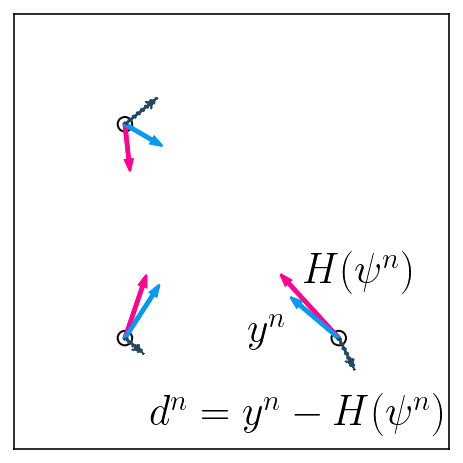

In [37]:
## Initial vector plot

ax = createInnovationPlot(ensemble, ideal_particle, iewpfOcean.S_host)
plt.savefig(imgdir + "1_prior_innovations.pdf", bbox_inches="tight", format='pdf')

In [38]:
## Store the state prior to adding 
## the Kalman gain, so that we 
## can subtract it for plotting the
## contribution.

pre_eta, pre_hu, pre_hv = ensemble.particles[ideal_particle].download(interior_domain_only=True)

In [39]:
# Kalman gain for all particles

for p in range(ensemble.getNumParticles()):
        # Pull particles towards observation by adding a Kalman gain term
        #     Also, we find phi within this function
        phi_array[p] = iewpfOcean.addKalmanGain(ensemble.particles[p], observed_drifter_positions, innovations[p], drifter_id=p)

        # Sample perpendicular xi and nu
        # Obtain gamma = xi^T * xi and nu^T * nu at the same time
        gamma_array[p], nu_norm_array[p] = iewpfOcean.samplePerpendicular(ensemble.particles[p])
            

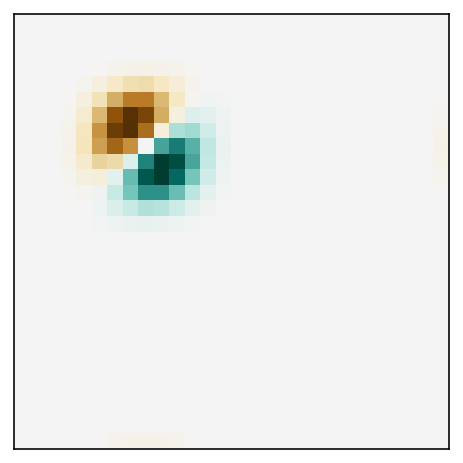

In [40]:
# Plot latest random numbers from the ideal particle

half_kalman_gain_soar = ensemble.particles[ideal_particle].small_scale_model_error.getCoarseBuffer()
imshow(half_kalman_gain_soar, 
       title=r'Latest random buffer')
#plt.savefig(imgdir + "5_soar2.pdf", bbox_inches="tight", format='pdf')

In [41]:
post_eta, post_hu, post_hv = ensemble.particles[ideal_particle].download(interior_domain_only=True)
kalman_eta = post_eta - pre_eta
kalman_hu  = post_hu  - pre_hu
kalman_hv  = post_hv  - pre_hv

hei


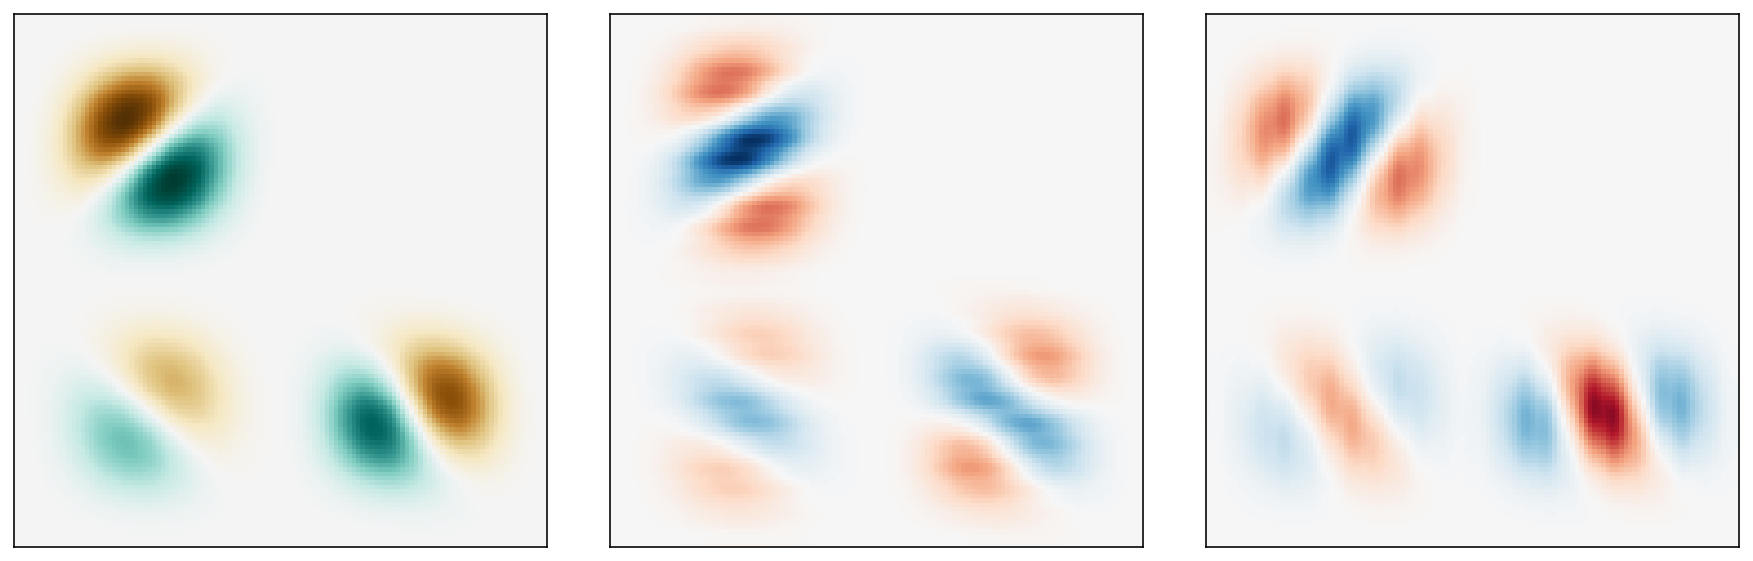

In [42]:
imshow3(kalman_eta, kalman_hu, kalman_hv)
        #title=r'Optimal proposal pull',
        #title_eta=r'$\eta$', title_hu=r'$hu$', title_hv=r'$hv$')
print("hei")
#plt.suptitle(r'$Q^{1/2}_{GB}I_{\Omega}Q^{1/2}_{SOAR}Q^{1/2}_{SOAR}Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$', 
#             y=1.0, fontsize=14)
plt.tight_layout()
plt.savefig(imgdir + "2_optimal_proposal_pull.pdf", bbox_inches="tight", format='pdf')

drifter_position [120.009796 120.01515 ]
true_velocity [1.94996381 3.01669121]
particle_velocity [1.78369951 3.13235569]
innovation:  [ 0.15646218 -0.13082884]
cell_id:  (30, 30)
drifter_position [359.98657 120.00803]
true_velocity [-2.72713113  2.31245995]
particle_velocity [-2.89785528  2.64508653]
innovation:  [ 0.16385708 -0.32680367]
cell_id:  (89, 30)
drifter_position [120.013336 359.9917  ]
true_velocity [ 1.88973868 -1.09623325]
particle_velocity [ 1.54757035 -1.39710307]
innovation:  [0.35781274 0.29179454]
cell_id:  (30, 89)


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/ma/core.py:713:

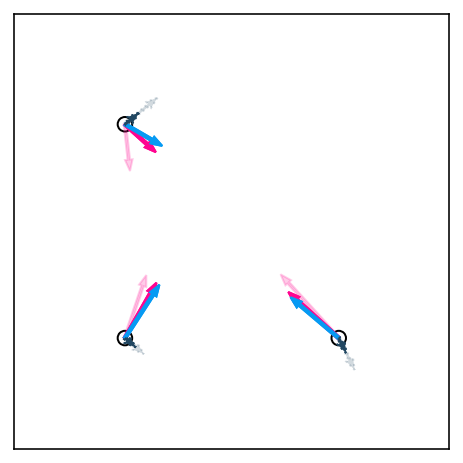

In [43]:
ax = createInnovationPlot(ensemble, ideal_particle, iewpfOcean.S_host, 
                          innovation_pre, all_particle_velocities_pre,
                          use_labels=False)
plt.savefig(imgdir + "3_mid_innovations.pdf", bbox_inches="tight", format='pdf')

In [44]:
## FIND TARGET WEIGHT AND THOSE THINGS:
c_array = phi_array + w_rest
target_weight, beta = iewpfOcean.obtainTargetWeightTwoStage(c_array, nu_norm_array)
print(target_weight)
print(beta)

8714.45919027712
0.8706156774747195


In [45]:
### Perturbation from P for ideal particle

# Solve implicit equation
c_star = target_weight - c_array[ideal_particle] - (beta - 1)*nu_norm_array[ideal_particle]
alpha = iewpfOcean.solveImplicitEquation(gamma_array[ideal_particle], target_weight, w_rest[ideal_particle],
                                   c_star, particle_id=ideal_particle)



# Update xi = \alpha^{1/2}*xi + \beta^{1/2}*\nu
iewpfOcean.addBetaNuIntoAlphaXi(ensemble.particles[ideal_particle], alpha, beta)

rand_numbers_pre = ensemble.particles[ideal_particle].small_scale_model_error.getRandomNumbers()

for drifter in range(ensemble.getNumDrifters()):
    observed_drifter_position = observed_drifter_positions[drifter,:]

    coarse_cell_id_x = int(np.floor(observed_drifter_position[0]/iewpfOcean.coarse_dx))
    coarse_cell_id_y = int(np.floor(observed_drifter_position[1]/iewpfOcean.coarse_dy))

    iewpfOcean.applyLocalSVDOnGlobalXi(ensemble.particles[ideal_particle],
                                       coarse_cell_id_x, coarse_cell_id_y)
    
rand_numbers_post = ensemble.particles[ideal_particle].small_scale_model_error.getRandomNumbers()

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/optimize/zeros.py:324: RuntimeWarning: Tolerance of 0.00014999999999998348 reached
  warnings.warn(msg, RuntimeWarning)


hei
hei


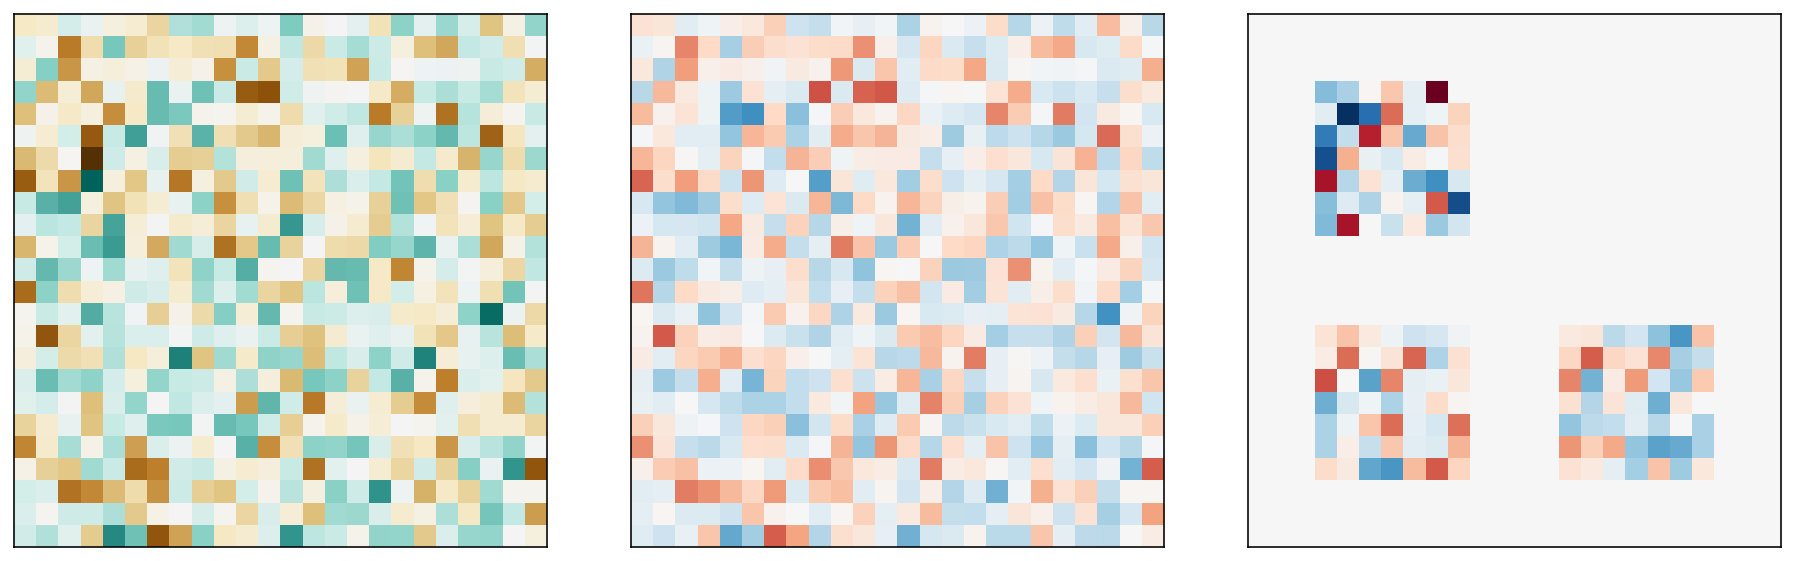

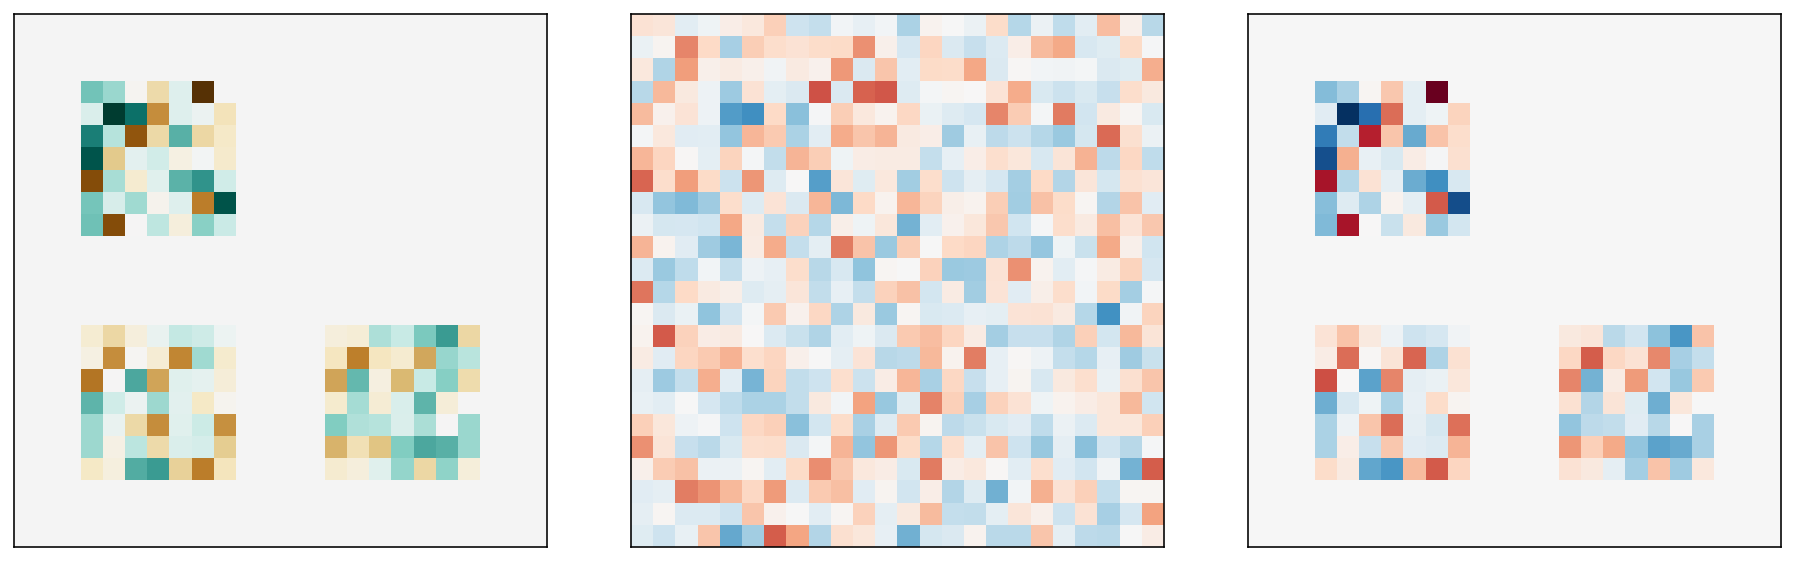

In [46]:
imshow3(rand_numbers_pre, rand_numbers_post, rand_numbers_post-rand_numbers_pre) #,
        #title_eta=r'$\xi_i$')
print("hei")
plt.savefig(imgdir + "4_SVD_effect_full.pdf", bbox_inches="tight", format='pdf')

imshow3(rand_numbers_post-rand_numbers_pre, rand_numbers_post, rand_numbers_post-rand_numbers_pre) #,
        #title_eta=r'Contribution from local SVD')
print("hei")
plt.savefig(imgdir + "4_SVD_effect_SVD_only.pdf", bbox_inches="tight", format='pdf')

In [47]:
# Apply covariance structure
ensemble.particles[p].small_scale_model_error.perturbSim(ensemble.particles[ideal_particle],\
                                                         update_random_field=False)

hei


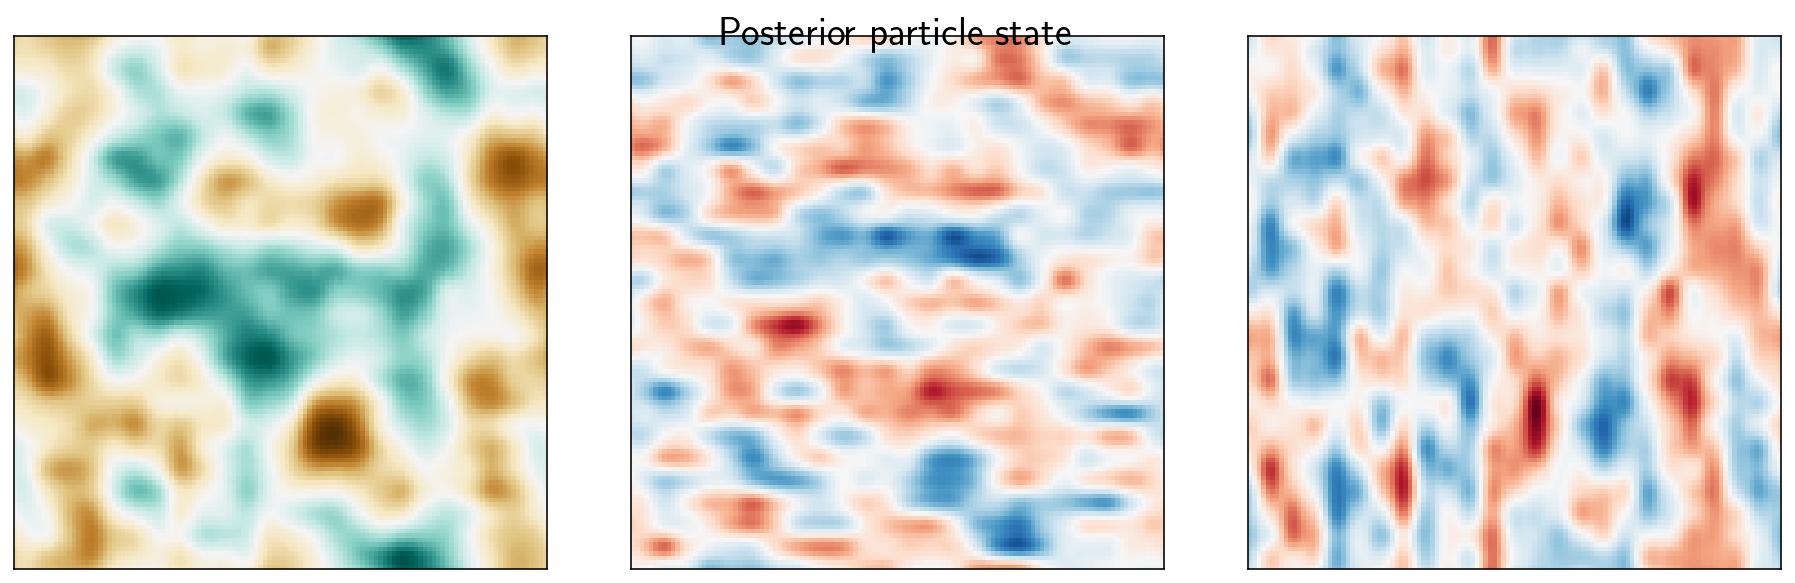

In [48]:
eta_fin, hu_fin, hv_fin = ensemble.particles[ideal_particle].download(interior_domain_only=True)
imshow3(eta_fin, hu_fin, hv_fin, title="Posterior particle state")
print("hei")
plt.savefig(imgdir + "5_posterior_state.pdf", bbox_inches="tight", format='pdf')

hei


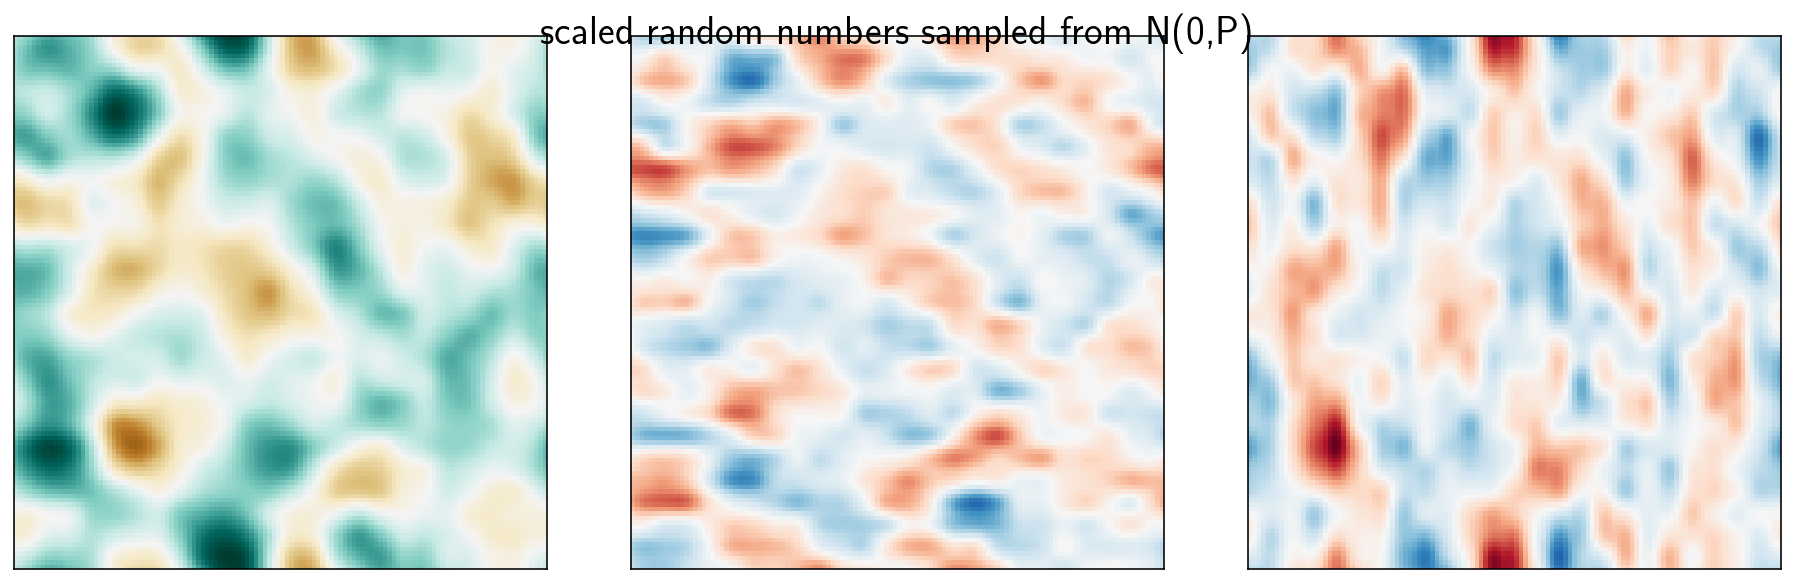

In [49]:
eta_P = eta_fin - post_eta
hu_P  = hu_fin  - post_hu
hv_P  = hv_fin  - post_hv

imshow3(eta_P, hu_P, hv_P, title="scaled random numbers sampled from N(0,P)")
print("hei")
plt.savefig(imgdir + "6_scaled_sample_from_P.pdf", bbox_inches="tight", format='pdf')

hei


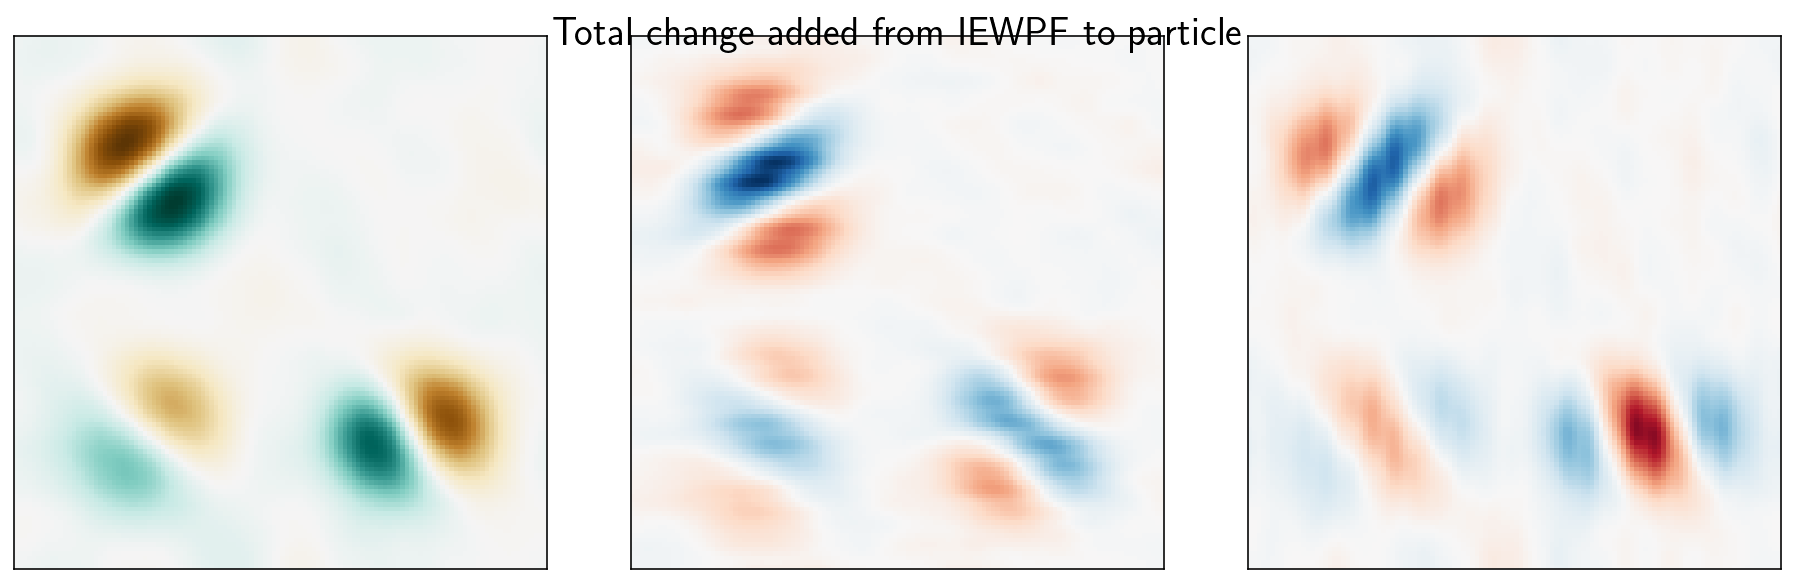

In [50]:
# Total change 

change_eta = eta_fin - pre_eta
change_hu  = hu_fin  - pre_hu
change_hv  = hv_fin  - pre_hv

imshow3(change_eta, change_hu, change_hv, title="Total change added from IEWPF to particle")
print("hei")
plt.savefig(imgdir + "7_total_change.pdf", bbox_inches="tight", format='pdf')

drifter_position [120.009796 120.01515 ]
true_velocity [1.94996381 3.01669121]
particle_velocity [1.74920952 3.17692304]
innovation:  [ 0.1907876  -0.17565079]
cell_id:  (30, 30)
drifter_position [359.98657 120.00803]
true_velocity [-2.72713113  2.31245995]
particle_velocity [-2.91333032  2.64428639]
innovation:  [ 0.17922678 -0.32591422]
cell_id:  (89, 30)
drifter_position [120.013336 359.9917  ]
true_velocity [ 1.88973868 -1.09623325]
particle_velocity [ 1.52029121 -1.44907641]
innovation:  [0.38500222 0.34381989]
cell_id:  (30, 89)


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/ma/core.py:713:

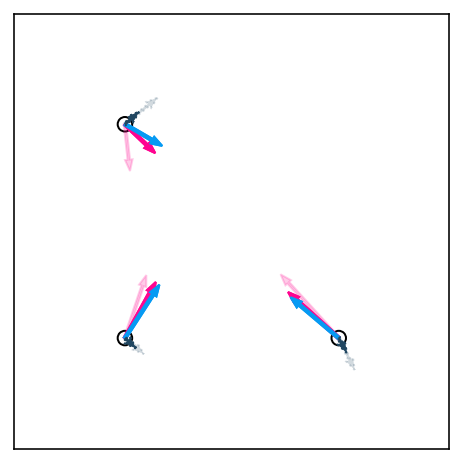

In [51]:
ax = createInnovationPlot(ensemble, ideal_particle, iewpfOcean.S_host, 
                          innovation_pre, all_particle_velocities_pre,
                          use_labels=False)
plt.savefig(imgdir + "8_posterior_innovations.pdf", bbox_inches="tight", format='pdf')

In [52]:
print(imgdir)

iewpf_loop_2019_08_13-18_42_33/
